# 미니 프로젝트 : 가위바위보 분류기를 만들자

## 1. 데이터 준비

### 1-1. 데이터 만들기
노트북 카메라를 이용하여 가위, 바위, 보 이미지 각 100장을 만들어본다. 구글의 teachable machine 사이트에서 쉽게 데이터를 만들 수 있다.

[https://teachablemachine.withgoogle.com/](https://teachablemachine.withgoogle.com/)

- 여러 각도에서 찍기
- 여러 크기로 찍기
- 여러 명이 찍기

좋은 데이터가 좋은 결과를 낳는다.

teachable machine을 통해서 이미지를 저장하면 이미지는 224x224 크기로 되어 있다.

### 1-2. 데이터 불러오기 + Resize 하기
가위, 바위, 보 이미지를 28x28로 만들어야 한다. 이를 위해 `PIL` 라이브러리를 사용한다.

In [1]:
from PIL import Image
import os, glob
# !nvidia-smi

In [2]:
import os

IMG_SIZE = 28 # 이미지 사이즈
total_image = 0 # 전체 이미지 개수

# 이미지를 리사이즈 해주는 함수
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")
    global total_image 
    total_image += len(images)
    
    print(f"{len(images)} images will be resized.")
    
    # resize all images to 28x28
    target_size=(IMG_SIZE, IMG_SIZE) # 28x28 size
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, "JPEG")
        
    print(f"{len(images)} images have been resized.\n")

In [3]:
# local
# data_dir = os.path.dirname(os.path.abspath('__file__')) # 현재 위치
# data_dir += r'/data/' # 데이터 폴더 위치
# print(data_dir)

# train_path = data_dir + r'train/'
# scissor_train_path = train_path + r'scissors/'
# rock_train_path = train_path + r'rock/'
# paper_train_path = train_path + r'paper/'

# train_paths = [scissor_train_path, rock_train_path, paper_train_path]
# print(train_paths)

In [4]:
scissor_dir = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
rock_dir = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
paper_dir = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"

# TODO: 폴더 존재하는지 체크해주는 부분 추가

img_dir = [scissor_dir, rock_dir, paper_dir]

In [5]:
from tqdm import tqdm

for image in tqdm(img_dir):
    resize_images(image)
    
print("이미지 resize 완료!")

  0%|          | 0/3 [00:00<?, ?it/s]

994 images will be resized.


 33%|███▎      | 1/3 [00:00<00:01,  1.51it/s]

994 images have been resized.

1105 images will be resized.


 67%|██████▋   | 2/3 [00:01<00:00,  1.96it/s]

1105 images have been resized.

1108 images will be resized.


100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

1108 images have been resized.

이미지 resize 완료!


In [6]:
# 총 이미지 개수
print(total_image)

3207


### 1-3. 가위, 바위, 보 데이터를 읽는 `load_data()` 함수 만들기

`load_data()` 함수는 입력으로 이미지가 있는 폴더 위치를 받는다. 여기서는 `rock_scissor_paper` 폴더 위치를 적어주면 된다.

In [7]:
import numpy as np

def load_data(img_path, number_of_data=300): 
    """    
    parameters:
        img_path: The directory path of the rock_scissor_paper
        number_of_data: The total nubmer of all images. Default value is 300.
    return:
        image data, label data
    """
    # scissors: 0, rock: 1, paper: 2
    img_size = IMG_SIZE
    color = 3
    
    # image data
    imgs = np.zeros(number_of_data * img_size * img_size * color, 
                    dtype=np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype=np.int32)
    
    idx = 0
    for file in glob.iglob(img_path + '/scissor/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0 # 가위 : 0
        idx = idx + 1
        
    for file in glob.iglob(img_path + '/rock/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 1 # 바위 : 1
        idx = idx + 1
    
    for file in glob.iglob(img_path + '/paper/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 2 # 보 : 2
        idx = idx + 1
        
    print(f"총 이미지 개수는 {idx} 입니다.")
    return imgs, labels

In [8]:
train_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"

(X, y) = load_data(train_data_path, number_of_data=3207)

총 이미지 개수는 3207 입니다.


### 1-4. train, test data 나누기

In [9]:
# train data와 test data 나누어 주기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (2565, 28, 28, 3)
y_train shape: (2565,)
X_test shape: (642, 28, 28, 3)
y_test shape: (642,)


In [10]:
# 정규화
X_train = X_train / 255.0   # 입력을 0~1 사이의 값으로 정규화

라벨:  2


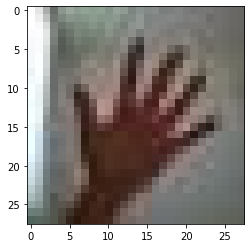

In [11]:
# 이미지 확인 (가위:0, 바위:1, 보:2)
import matplotlib.pyplot as plt

plt.imshow(X_train[1000])
print('라벨: ', y_train[1000])

## 2. 딥러닝 네트워크 설계하기

In [12]:
import tensorflow as tf
from tensorflow import keras

# VGGNet
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_size=(3, 3), 
                           filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=256, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0

## 3. 딥러닝 네트워크 학습시키기

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history = model.fit(X_train, y_train, epochs=25, validation_split=0.25)

Epoch 1/25
61/61 [==============================] - 14s 127ms/step - loss: 1.4587 - accuracy: 0.3186 - val_loss: 1.2418 - val_accuracy: 0.3536
Epoch 2/25
61/61 [==============================] - 1s 16ms/step - loss: 1.1708 - accuracy: 0.3110 - val_loss: 1.1212 - val_accuracy: 0.3505
Epoch 3/25
61/61 [==============================] - 1s 15ms/step - loss: 1.1264 - accuracy: 0.3558 - val_loss: 1.1034 - val_accuracy: 0.3505
Epoch 4/25
61/61 [==============================] - 1s 15ms/step - loss: 1.1249 - accuracy: 0.3336 - val_loss: 1.1112 - val_accuracy: 0.3536
Epoch 5/25
61/61 [==============================] - 1s 15ms/step - loss: 1.1117 - accuracy: 0.3685 - val_loss: 1.0389 - val_accuracy: 0.4470
Epoch 6/25
61/61 [==============================] - 1s 15ms/step - loss: 1.0342 - accuracy: 0.4398 - val_loss: 0.8752 - val_accuracy: 0.6044
Epoch 7/25
61/61 [==============================] - 1s 15ms/step - loss: 0.9026 - accuracy: 0.5346 - val_loss: 0.8592 - val_accuracy: 0.5436
Epoch 8/25


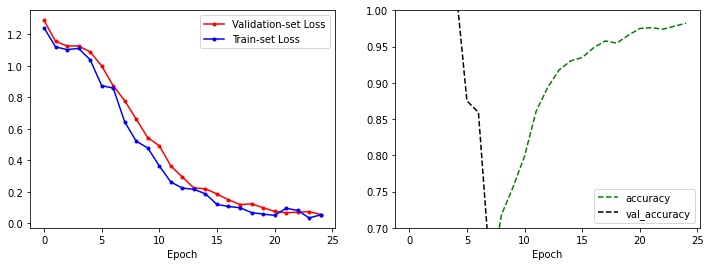

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='.', c='red', label='Validation-set Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='Train-set Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g--', label='accuracy')
plt.plot(history.history['val_loss'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

## 4. test 데이터로 테스트

In [17]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

21/21 - 0s - loss: 74.6911 - accuracy: 0.8427
test_loss: 74.6911392211914
test_accuracy: 0.8426791429519653


In [18]:
predicted_result = model.predict(X_test) # model이 추론한 확률값
predicted_labels = np.argmax(predicted_result, axis=1) # 확률의 최대값이 예측하는 숫자를 뜻한다

idx = 324
print(f"models.predict() 결과: {predicted_result[idx]}\n")
print(f"model이 추론한 가장 가능성이 높은 결과 : ", predicted_labels[idx])
print(f"실제 데이터의 라벨 : ", y_test[idx])

models.predict() 결과: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


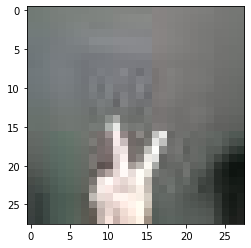

In [19]:
# 실제 이미지 출력
plt.imshow(X_test[idx], cmap=plt.cm.binary)
plt.show()

## 5. 완전히 새로운 데이터로 테스트

In [20]:
scissor_test = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
rock_test = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
paper_test = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
test_path = paper_test_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

test_paths = [scissor_test, rock_test, paper_test]

# 새로운 데이터 리사이즈
for path in test_paths:
    resize_images(path) 

(X_new, y_new)=load_data(test_path)
X_new_norm = X_new / 255.0



test_loss, test_accuracy = model.evaluate(X_new_norm, y_new, verbose=2)

print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

100 images will be resized.
100 images have been resized.

100 images will be resized.
100 images have been resized.

100 images will be resized.
100 images have been resized.

총 이미지 개수는 300 입니다.
10/10 - 2s - loss: 2.9662 - accuracy: 0.7100
test_loss: 2.9661595821380615
test_accuracy: 0.7099999785423279


## 6. 더 좋은 네트워크 만들어보기
- [x] 더 많은 데이터 추가하기
- [x] Validation Set 만들기
- [x] 하이퍼파라미터 변경
- [x] 딥러닝 모델 바꾸기

### 6-1. 이미지 보강

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

image_generator = ImageDataGenerator(
            rotation_range=10,
            zoom_range=0.10,
            shear_range=0.5,
            width_shift_range=0.10,
            height_shift_range=0.10,
            horizontal_flip=True,
            vertical_flip=False)

augment_size = 100

x_augmented = image_generator.flow(np.tile(X_train[0].reshape(IMG_SIZE*IMG_SIZE), 100).reshape(-1, 28, 28, 1),
                     np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]

ValueError: cannot reshape array of size 2352 into shape (784,)

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import numpy as np

# image_generator = ImageDataGenerator(
#             rotation_range=10,
#             zoom_range=0.10,
#             shear_range=0.5,
#             width_shift_range=0.10,
#             height_shift_range=0.10,
#             horizontal_flip=True,
#             vertical_flip=False)

# augment_size = 30000

# randidx = np.random.randint(X_train.shape[0], size=augment_size)
# x_augmented = X_train[randidx].copy()
# y_augmented = y_train[randidx].copy()
# x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size),
#                                    batch_size=augment_size, shuffle=False).next()[0]

In [ ]:
# X_train = np.concatenate((X_train, x_augmented))
# y_train = np.concatenate((y_train, y_augmented))

# print(X_train.shape)

### 6-2. 다시 학습 및 테스트

In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_size=(3, 3), 
#                            filters=32, padding='same', activation='relu'),
#     tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'),
#     tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
#     tf.keras.layers.Dropout(rate=0.5),
#     tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=128, padding='same', activation='relu'),
#     tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=256, padding='valid', activation='relu'),
#     tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
#     tf.keras.layers.Dropout(rate=0.5),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=512, activation='relu'),
#     tf.keras.layers.Dropout(rate=0.5),
#     tf.keras.layers.Dense(units=256, activation='relu'),
#     tf.keras.layers.Dropout(rate=0.5),
#     tf.keras.layers.Dense(units=10, activation='softmax')
# ])

# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=25, validation_split=0.25)

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], marker='.', c='red', label='Validation-set Loss')
# plt.plot(history.history['val_loss'], marker='.', c='blue', label='Train-set Loss')
# plt.xlabel('Epoch')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], 'g--', label='accuracy')
# plt.plot(history.history['val_loss'], 'k--', label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylim(0.7, 1)
# plt.legend()

# plt.show()

In [ ]:
# test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

# print(f"test_loss: {test_loss}")
# print(f"test_accuracy: {test_accuracy}")

## 7. 결론